In [1]:
# load data

from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups()
docs = newsgroups.data
target = newsgroups.target

In [2]:
# format for the DTM

documents = [
    {
        "text": doc,
        "timestamp": i,
    }
    for i,doc in enumerate(docs)
]

n_windows = 10
window_size = len(docs) / n_windows
windows = [
    {
        "label": "Section {}".format(i),
        "start": i * window_size,
        "end": (i+1) * window_size,
    }
    for i in range(n_windows)
]

data = {
    "documents": documents,
    "windows": windows
}

In [3]:
# save

import json

news_file = 'news_data.json'
with open(news_file, 'w') as f:
    f.write(json.dumps(data))

In [4]:
import os

from dtm import fit
from models import DTM
from utils import setup_logging

new_model_path = 'news_model.dill'

setup_logging()
dtm, tokenizer, tfidf = fit(data)
dtm.save(new_model_path)

2017-04-24 22:08:38,099 - dtm - INFO - Tokenizing
2017-04-24 22:12:07,882 - dtm - INFO - Fitting TF-IDF
2017-04-24 22:12:12,185 - dtm - INFO - Training GloVe
2017-04-24 22:14:08,602 - dtm - INFO - Separating by windows
2017-04-24 22:14:08,623 - dtm - INFO - Fitting topics
2017-04-24 22:14:08,646 - models - INFO - Fitting window topics
2017-04-24 22:14:08,647 - models - INFO - Fitting topics for window (1/10)
2017-04-24 22:14:40,151 - models - INFO - Fitting topics for window (2/10)
2017-04-24 22:15:12,405 - models - INFO - Fitting topics for window (3/10)
2017-04-24 22:15:35,991 - models - INFO - Fitting topics for window (4/10)
2017-04-24 22:16:05,712 - models - INFO - Fitting topics for window (5/10)
2017-04-24 22:16:31,970 - models - INFO - Fitting topics for window (6/10)
2017-04-24 22:17:05,335 - models - INFO - Fitting topics for window (7/10)
2017-04-24 22:17:34,669 - models - INFO - Fitting topics for window (8/10)
2017-04-24 22:18:06,136 - models - INFO - Fitting topics for wi

In [6]:
# print results

from models import print_topics

n_dynamic_topics = len(dtm.dynamic_topics)
print("Found {} dynamic topics".format(n_dynamic_topics))
print_topics(dtm.dynamic_topics)

Found 40 dynamic topics
Topic 1

key
chip
clipper
encryption
escrow
government
system
phone
algorithm
crypto
secret
nsa
des
security
bit
secure
wiretap
public
encrypt
privacy


Topic 2

game
team
player
play
win
hockey
year
season
baseball
score
league
fan
nhl
playoff
last
toronto
espn
run
detroit
division


Topic 3

god
jesus
christian
believe
bible
christians
church
life
faith
religion
christ
christianity
truth
man
atheist
come
word
sin
belief
thing


Topic 4

windows
window
file
dos
ms
program
run
system
nt
os
microsoft
manager
disk
ini
icon
access
delete
win
pc
software


Topic 5

scsi
ide
controller
bus
isa
pc
drive
mac
device
mb
adaptec
seagate
ibm
quadra
eisa
os
spec
hd
tape
data


Topic 6

gun
weapon
firearm
criminal
crime
control
right
law
bill
drug
knife
police
fbi
government
homicide
tank
public
carry
amendment
individual


Topic 7

banks
gordon
n3jxp
chastity
shameful
skepticism
intellect
surrender
pittsburgh
science
univ
soon
computer
disease
lyme
blood
weight
brain
pain
p

In [10]:
# get the dynamic topic distributions over the documents

import numpy as np

tokenized = tokenizer.tokenize(docs)
vectorized = tfidf.transform(
    ' '.join(tokens)
    for tokens in tokenized
)

ValueError: dimension mismatch

In [31]:
topic_ordered_index = [tfidf.get_feature_names().index(word) for word in dtm.dynamic_topics[0].vocab]
vectorized_only_topic_terms = vectorized[:, topic_ordered_index]

In [32]:
weights = np.vstack(topic.term_weights for topic in dtm.dynamic_topics)
topic_distributions = vectorized_only_topic_terms.dot(weights.T)

In [71]:
# calculate the target and predicted class similarities for a random pairing of documents

import numpy as np
from scipy import spatial

index = np.arange(len(docs))
np.random.shuffle(index)

target_similarity = (target == target[index]).astype('f')
predicted_similarity = np.array([
    (1 - spatial.distance.cosine(a, b))
    for a, b in zip(topic_distributions, topic_distributions[index,:])])

target_similarity = target_similarity[~np.isnan(predicted_similarity)]
predicted_similarity = predicted_similarity[~np.isnan(predicted_similarity)]

/Users/luke/.virtualenvs/nlp_final/lib/python3.6/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [91]:
# take an equal number from each class and measure the log loss

from sklearn.metrics import log_loss, accuracy_score

n_samples = 500

assert(len([target_similarity == 1][:n_samples]) == len([target_similarity == 0][:n_samples]))

positive_pred = predicted_similarity[target_similarity == 1][:n_samples]
negative_pred = predicted_similarity[target_similarity == 0][:n_samples]
pred = np.hstack([positive_pred, negative_pred])

positive_true = np.ones(n_samples).T
negative_true = np.zeros(n_samples).T
true = np.hstack([positive_true, negative_true])

cross_emp_score = log_loss(true, pred)
print(cross_emp_score)

0.53532389379


In [92]:
# random choice

positive_pred = np.random.random(predicted_similarity.shape)[target_similarity == 1][:n_samples]
negative_pred = np.random.random(predicted_similarity.shape)[target_similarity == 0][:n_samples]
random_pred = np.hstack([positive_pred, negative_pred])

cross_emp_score = log_loss(true, random_pred)
print(cross_emp_score)

1.02232459435


In [94]:
# reduce dimensionality for graphing

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd = TruncatedSVD(n_components=50)
reduced = svd.fit_transform(vectorized)

tsne = TSNE(n_components=2)
two_d = tsne.fit_transform(reduced)

Coloized by class targets


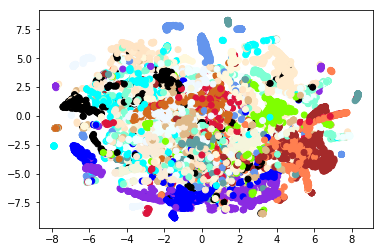

In [97]:
print("Coloized by class targets")

target_colors = [list(mcolors.cnames.keys())[i] for i in range(len(set(target)))]
plt.scatter(two_d[:,0], two_d[:,1], color=np.array(target_colors)[target])

Coloized by highest probability topic


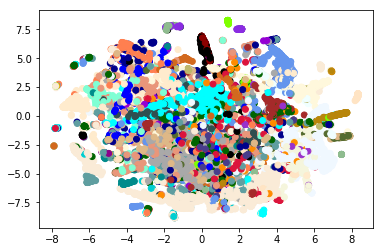

In [96]:
print("Coloized by highest probability topic")

predicted_topic = np.argmax(topic_distributions, axis=1)
target_colors = [list(mcolors.cnames.keys())[i] for i in range(len(set(predicted_topic)))]
plt.scatter(two_d[:,0], two_d[:,1], color=np.array(target_colors)[predicted_topic])